In [1]:
import torch
import numpy as np
import nibabel as ni
import os, shutil
import time
import random
import pandas as pd
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import loss
import torchio as tio

/home/umeleti/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'

In [3]:
class MRI_dataloader(Dataset):
    def __init__(self, path, img_size=(137, 128, 128)):
        self.path = path
        self.filenames = [i for i in os.listdir(path) if i.endswith(".nii")]
        #self.upsample = torch.nn.Upsample(size=(137, 128, 128), mode='trilinear', align_corners=True)
        self.img_size = img_size
        
    def __getitem__(self, index):
        image = ni.load(os.path.join(self.path, self.filenames[index]))
        image = np.array(image.dataobj)
        image = np.moveaxis(image, [0, 1], [1, 0])
        img_scale = tuple([self.img_size[i]/image.shape[i] for i in range(len(image.shape))])
        image = zoom(image, img_scale)
        image = image / 255.
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
        #image = torch.permute(image, (1, 0, 2)).unsqueeze(0)
        return image
    
    def __len__(self):
        return len(self.filenames)

In [4]:
path = 'dataset/images'
mri_loader = MRI_dataloader(path)
batch_size = 8
dataloader = DataLoader(mri_loader, batch_size=batch_size, shuffle=True)
for batch in dataloader:
    break


In [31]:
# Augmentations
path = 'dataset/images'
filenames = [i for i in os.listdir(path) if i.endswith(".nii")]
image = ni.load(os.path.join(path, filenames[0]))
image = np.array(image.dataobj)
image = np.moveaxis(image, [0, 1], [1, 0])
img_size=(137, 128, 128)
img_scale = tuple([img_size[i]/image.shape[i] for i in range(len(image.shape))])
image = zoom(image, img_scale)

# image[image > 0.1] = 1
# image[image != 1] = 0
print(np.max(image), np.min(image))
# # image = image / 255.
image = torch.from_numpy(image)
image = image.unsqueeze(0) # expand channels

0.86055154 -1.0005772e-13


In [27]:
# image.shape

In [190]:
# help(tio)
# (C, W, H, D)

In [32]:
# transforms_dict = {
# #     tio.RandomAffine(): 0.3,
# #     tio.RandomElasticDeformation():1
#     tio.RandomBlur():1
#     tio.RandomBiasField()
#     tio.RandomSpike()
#    tio.RandomGhosting()
#     tio.RandomMotion()
    
# #     tio.RandomGamma():1
# #     tio.RandomNoise(): 1
# }

transforms_list = [tio.RandomBlur(), tio.RandomBiasField(),
                  tio.RandomSpike(), tio.RandomGhosting(), tio.RandomMotion(),
                  tio.RandomGamma(), tio.RandomNoise()]


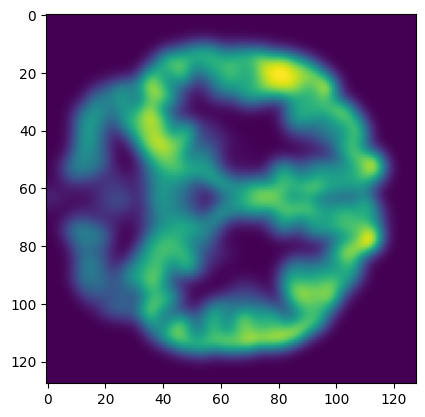

In [33]:
transform = tio.OneOf(transforms_list)
image_ = image.permute((0,2,3,1))
image_ = transform(image_)
# plt.imshow(image.numpy()[0,:,:, 50])
plt.imshow(image_.numpy()[0,:,:, 50])

In [53]:
len(dataloader)

22

In [54]:
len(mri_loader)

171

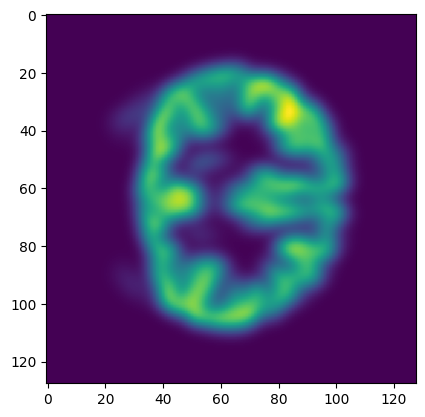

In [43]:
i = 100
img = batch.cpu().detach().numpy()[0,0,i,:,:]
plt.imshow(img*255.0)

In [32]:
from model import VAE

In [34]:
model = VAE().to(device)
batch = batch.to(device)

out = model(batch)

torch.Size([8, 32, 18, 16, 16])
torch.Size([8, 16, 35, 32, 32])
torch.Size([8, 8, 69, 64, 64])
torch.Size([8, 4, 137, 128, 128])


In [35]:
out[0].shape

torch.Size([8, 1, 137, 128, 128])

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-7)

In [46]:
y, z_mean, z_log_sigma = model(batch)

torch.Size([8, 32, 18, 16, 16])
torch.Size([8, 16, 35, 32, 32])
torch.Size([8, 8, 69, 64, 64])
torch.Size([8, 4, 137, 128, 128])


In [51]:
criterion_rec = loss.L1Loss()
criterion_dis = loss.KLDivergence()
loss_rec_batch = criterion_rec(batch, y)
loss_KL_batch = criterion_dis(z_mean, z_log_sigma)
total_loss_batch = loss_rec_batch + loss_KL_batch

In [52]:
total_loss_batch.backward()
optimizer.step()

In [11]:
def load_mri_images(path, batch_size):
    filenames = [i for i in os.listdir(path) if i.endswith(".nii")] #and i.startswith("norm_023_S_0030")
    random.shuffle(filenames, random.random)
    n = 0
    while n < len(filenames):
        batch_image = []
        for i in range(n, n + batch_size):
            if i >= len(filenames):
                ##n = i
                break
            #print(filenames[i])
            image = ni.load(os.path.join(path, filenames[i]))
            image = np.array(image.dataobj)
            image = torch.Tensor(image)
            image = torch.permute(image, (1, 0, 2)).unsqueeze(0).unsqueeze(1)
            
            image = image / 255.
            batch_image.append(image)
        n += batch_size
        batch_image = torch.cat(batch_image, axis=0)
        yield batch_image

In [13]:
for batch in load_mri_images(path, 8):
    break

/local_scratch/pbs.2209445.pbs02/ipykernel_2805981/2230783284.py:3: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(filenames, random.random)


In [14]:
batch.shape

torch.Size([8, 1, 137, 113, 113])

In [15]:
up = torch.nn.Upsample(size=(137, 128, 128), mode='trilinear', align_corners=True)
reshaped = up(batch)

In [16]:
reshaped.shape

torch.Size([8, 1, 137, 128, 128])

In [20]:
x = np.zeros((3, 4, 5))
np.moveaxis(x, [0, 1, 2], [2, 1, 0]).shape

(5, 4, 3)